# Feedforward Neural Network With TensorFlow

In [221]:
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

We being by loading the dataset, one-hot encoding it, and splitting it between train and test set

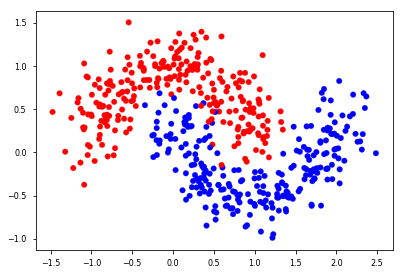

In [224]:
n_samples = 500
data, labels = make_moons(n_samples=n_samples, noise=0.2, random_state=42)
plt.scatter(*data.T, c=labels, cmap=cmap_bold);

In [209]:
ohe = OneHotEncoder(sparse=False)

X = data
y = ohe.fit_transform(labels.reshape(-1, 1))

X_train, X_test = train_test_split(X, test_size=0.2, random_state=1643)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=1643)

In [217]:
# Meshgrid to plot decision function

epsilon = 0.1
x1_min, x2_min = X_test.min(0) - epsilon
x1_max, x2_max = X_test.max(0) + epsilon

x1, x2 = np.mgrid[x1_min:x1_max:0.01, x2_min:x2_max:0.01]

## Single Hidden Layer

We consider single-hidden layer the neural network
$$
    \hat{y} = \sigma\left(X \cdot W + b\right) \in \mathbb R ^{n \times 2}
$$
With, 

$
    X \in \mathbb R ^{n\times2}\\
    W \in \mathbb R ^ {2 \times 2}\\
    b \in \mathbb R ^ {2} \text{; a column vector}
$

In [250]:
# We input data into X, it is a static parameter
X = tf.placeholder(tf.float32, [None, 2])
# Initialization of the parameters to learn as zero.
W = tf.Variable(tf.zeros([2, 2]))
b = tf.Variable(tf.zeros([2]))
# Initialize all the variables
init = tf.global_variables_initializer()

## The model to train and actual parameters ##
y = tf.placeholder(tf.float32, [None, 2])
y_hat = tf.nn.softmax(X @ W + b)

# Model metrics
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat)
correct_guess = tf.equal(tf.arg_max(y, 1), tf.arg_max(y_hat, 1))
accuracy = tf.reduce_mean(tf.cast(correct_guess, tf.float32))

# Setting the optimizer 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.03)
train_step = optimizer.minimize(cross_entropy)

Final accuracy on train:  85.500%
Final accuracy on test:  89.000%


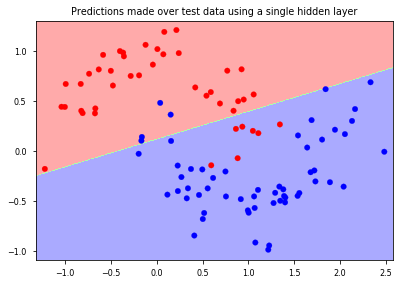

In [251]:
epochs = 10_000
with tf.Session() as sess:
    # Given the small amount of data,
    # we do batch-gradient descent
    train_data = {X: X_train, y: y_train}
    test_data = {X: X_test, y: y_test}
    sess.run(init)
    for epoch in range(epochs):
        # Forwardprop, backprop and weights update
        sess.run(train_step, feed_dict=train_data)
        # Validate metrics
        
    acc_train = sess.run(accuracy, feed_dict=train_data)
    acc_test = sess.run(accuracy, feed_dict=test_data)
    y_grid = sess.run(y_hat, feed_dict={X: np.c_[x1.ravel(), x2.ravel()]})
    print(f"Final accuracy on train: {acc_train: 0.3%}")
    print(f"Final accuracy on test: {acc_test: 0.3%}")

plt.title("Predictions made over test data using a single hidden layer")
plt.contourf(x1, x2, np.argmax(y_grid, 1).reshape(x1.shape), cmap=cmap_light)
plt.scatter(*X_test.T, c=(y_test @  np.array([0, 1])), cmap=cmap_bold);

## 3 hidden-layer neural network

We consider three-hidden layer the neural network
$$
    \hat{y} = \sigma(\sigma(\sigma(X \cdot W_1 + b_1) \cdot W_2 + b_2) \cdot W_3 + b_3) \in \mathbb{R}^{n\times 2}
$$
With, 

$n_i$: Number units in the $i$-th layer. $n_3 = 2$

$
    X \in \mathbb R ^{n_0 \times n_1}\\
    W_i \in \mathbb R ^ {n_{i-1} \times n_{i}} \  \forall \ i \in \{1, 2, 3\} \\
    b_i \in \mathbb R ^ {n_i} \  \forall \ i \in \{1, 2, 3\} 
$

In [327]:
n1, n2, n3 = 3, 5, 2

X = tf.placeholder(tf.float32, [None, 2])

W1, b1 = tf.Variable(tf.truncated_normal([2, n1], stddev=0.1)), tf.zeros([n1])
W2, b2 = tf.Variable(tf.truncated_normal([n1, n2], stddev=0.1)), tf.zeros([n2])
W3, b3 = tf.Variable(tf.truncated_normal([n2, n3], stddev=0.1)), tf.zeros([n3])
init = tf.global_variables_initializer()

y = tf.placeholder(tf.float32, [None, n3])

y1 = tf.nn.relu(X @ W1 + b1)
y2 = tf.nn.relu(y1 @ W2 + b2)
y_hat = tf.nn.softmax(y2 @ W3 + b3)

# Model Metrics
cross_entropy = -tf.reduce_sum(y * tf.log(y_hat))
correct_guess = tf.equal(tf.arg_max(y, 1), tf.arg_max(y_hat, 1))
accuracy = tf.reduce_mean(tf.cast(correct_guess, tf.float32))

# Setting the optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train_step = optimizer.minimize(cross_entropy)

Final accuracy on train:  85.500%
Final accuracy on test:  87.000%


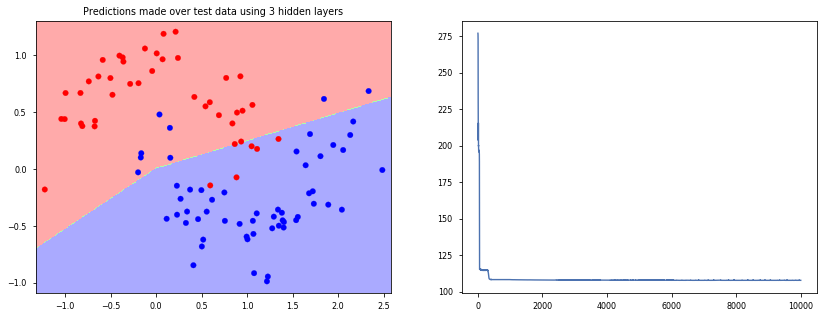

In [328]:
epochs = 10000
with tf.Session() as sess:
    cost_hist = []
    # Given the small amount of data,
    # we do batch-gradient descent
    train_data = {X: X_train, y: y_train}
    test_data = {X: X_test, y: y_test}
    sess.run(init)
    for epoch in range(epochs):
        # Forwardprop, backprop and weights update
        sess.run(train_step, feed_dict=train_data)
        cost_i = sess.run(cross_entropy, feed_dict=train_data)
        cost_hist.append(cost_i)
        
    acc_train = sess.run(accuracy, feed_dict=train_data)
    acc_test = sess.run(accuracy, feed_dict=test_data)
    y_grid = sess.run(y_hat, feed_dict={X: np.c_[x1.ravel(), x2.ravel()]})
    print(f"Final accuracy on train: {acc_train: 0.3%}")
    print(f"Final accuracy on test: {acc_test: 0.3%}")

fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Predictions made over test data using 3 hidden layers")
ax1.contourf(x1, x2, np.argmax(y_grid, 1).reshape(x1.shape), cmap=cmap_light)
ax1.scatter(*X_test.T, c=(y_test @  np.array([0, 1])), cmap=cmap_bold);

ax2.plot(cost_hist)